# COMP41680 Assignment 2 : Text Scraping and Classification

# Name : ABHINAY KANDI
# Student ID : 17200526

# Part 1. Data Collection 

In [2]:
#loading libraries
import urllib.request
import requests
import nltk
import os.path
import numpy as np
import pandas as pd
import nltk
import re
import os
import string
from bs4 import BeautifulSoup
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Identify the URLs and category labels for all news articles listed on the website:
http://mlg.ucd.ie/modules/COMP41680/archive/index.html

In [3]:
URL="http://mlg.ucd.ie/modules/COMP41680/archive/index.html"
url=re.match("^http://.*/",URL).group() #pattern matching
url

'http://mlg.ucd.ie/modules/COMP41680/archive/'

In [4]:
#main page links
main_link=[]
month=[]
page = urllib.request.urlopen("http://mlg.ucd.ie/modules/COMP41680/archive/index.html")
html_page =page.read().decode("utf-8")
soup = BeautifulSoup(html_page,'html.parser')
for link in soup.findAll('a',href=lambda x: x and x.startswith('month')):
    main_link.append(url+link.get('href'))
    month.append(link.get_text())
page.close()    
month
main_link

['http://mlg.ucd.ie/modules/COMP41680/archive/month-jan-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-feb-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-mar-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-apr-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-may-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-jun-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-jul-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-aug-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-sep-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-oct-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-nov-2017.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/month-dec-2017.html']

Above I'm fetching the links in the main page, which will be used to get the inner links from each of the 12 links.

In [5]:
#all links in the corpus
all_link=[] # to store all 1408 links
titles=[] # to store titles
for x in main_link:
    x_url=urllib.request.urlopen(x)
    all_url =x_url.read().decode("utf-8")
    soup1 = BeautifulSoup(all_url,'html.parser')
    for link in soup1.find_all('a',href=lambda x: x and x.startswith('article')): #to find all the sentences that have tag 'a' and href with start with article
        if(link!=""):
            all_link.append(url+link.get('href'))
            titles.append(link.get_text()) # getting titles from all the  1408 links
    x_url.close()
all_link 

['http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-0418.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-0027.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-0631.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-2105.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-3300.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-4187.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-1974.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-3666.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-2629.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-2415.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-4210.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-4789.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-3452.html',
 'http://mlg.ucd.ie/modules/COMP41680/archive/article-jan-2428.html',
 'http://mlg.ucd.ie/

Above are all the links (1408) in the corpus which will used to fetch the main body text from each link.

### 2. Retrieve all web pages corresponding to these article URLs. From the web pages, extract the main body text containing the content of each news article. Save the body of each article as plain text

### 3. Save the category labels for all articles in a separate file.

In [6]:
#category
category=[]
for x in main_link:
    url=urllib.request.urlopen(x)
    c_url =url.read().decode("utf-8")
    soup1 = BeautifulSoup(c_url,'html.parser')
    for link in soup1.find('div',class_="main").find_all('td',class_="category"): # fetching all the td tags
        a=link.get_text()
        a=a[1:]
        if(a!="N/A"):
            category.append(a) #adding category if the title is not N/A
        url.close()
len(category)
file = open("category.txt",'w',encoding="utf-8") # Writing categories to a separate file called category.txt
file.write(str(category))
file.close()

In [7]:
print(set(category))

{'sport', 'business', 'technology'}


From the above, I got to know that there are 3 unique news categories in the corpus.

In [8]:
fd = pd.DataFrame({"labels": category})
category_types=['business', 'sport', 'technology']
fd['Category']=fd['labels'].astype("category",categories=category_types).cat.codes
fd.head()

,labels,Category
0,technology,2
1,business,0
2,technology,2
3,business,0
4,sport,1


Each example in the dataset has a class label or a "target" from three possible classes. Above I'm normalising the nominal values to ordinal values which is given as target to classification algorithm.

In [9]:
short_link=[] # to store all the file names eg: article-jan-0418
text2=set()
for x in all_link:
    filename=x.split("/")[-1][:-5]
    short_link.append(filename)
    text_url=requests.get(x)
    soup2 = BeautifulSoup(text_url.content,'html.parser')
    item=soup2.find('div',class_="main").find_all('p',class_="") # fetching all p tags
    item1=soup2.find('div',class_="main").find('h2') # fetching heading of the main body text
    if not os.path.exists(filename):   # write if file is not present
        file = open('raw_documents.txt','a',encoding="utf-8")
        file.write(item1.get_text()+" | ") # Writing Title where title and main body text are separated by '|'
        for x in item:
            file.write(x.get_text()) # writing the main body text
        file.write("\n") # Each main body text of links are separated br new line
        file.close()
    text_url.close()

In [10]:
show=pd.DataFrame({"File":short_link,"Title":titles,"Label":fd['labels'],"Category":fd['Category']},columns=['File','Title','Label','Category'])
show.head()

,File,Title,Label,Category
0,article-jan-0418,21st-Century Sports: How Digital Technology Is...,technology,2
1,article-jan-0027,Asian quake hits European shares,business,0
2,article-jan-0631,BT offers free net phone calls,technology,2
3,article-jan-2105,Barclays shares up on merger talk,business,0
4,article-jan-3300,Barkley fit for match in Ireland,sport,1


The above DataFrame is just for understanding in perspective of the viewer

Label
business      491
sport         526
technology    391
dtype: int64


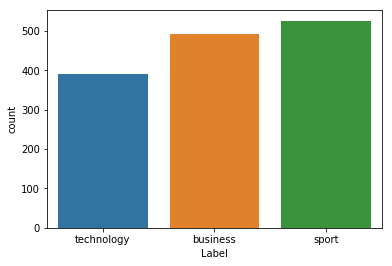

In [11]:
print(show.groupby('Label').size())
sns.countplot(show['Label'])
plt.show()

The data is pretty balanced based on the above chart

# Part 2. Text Classification 

### 1. From the files created in Part 1, load the set of raw documents into your notebook.

In [12]:
fin = open("raw_documents.txt","r",encoding="utf-8")
raw_documents = fin.readlines() #reading for the file

### 2. From the raw documents, create a document-term matrix, using appropriate text pre-processing and term weighting steps. 

In [13]:
def lemma_tokenizer(text):
    # the standard scikit-learn tokenizer
    standard_tokenizer = CountVectorizer(lowercase=True).build_tokenizer() # lower casing the tokens
    tokens = standard_tokenizer(text)
    # use of NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer() # Doing a Word Net lemmatizer
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

Above I'm doing lower casing an then tokenising (The tokenization splits the source file into individual tokens. It is used for syntax highlighting. Here, punctuation is treated as a separate token.) Then applying a WordNet lemmatizer to those tokens. lemmatization is good with plurals, words ending with -ing, -es, and other commoners like is, are, am, etc. WordNet Lemmatizer works only with noun, verb and adjective. So, any other form needs to be
converted to these forms. Lemmatization is slower and it removes affixes if the word is in the given dictionary.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english",min_df = 12,tokenizer=lemma_tokenizer) # building tfidf
X = tfidf.fit_transform(raw_documents)
X.shape

(1408, 3195)

Above I'm taking minimum document frequency = 12. So there are 3195 words that appear in atleast 12 documents. I'm generating TF-IDF weighted document-term matrix by using TfidfVectorizer().

In [56]:
print(X[0])

  (0, 44)	0.109743238189
  (0, 542)	0.100437162172
  (0, 2699)	0.191279822343
  (0, 884)	0.130754333036
  (0, 2870)	0.165285050876
  (0, 557)	0.0941317754783
  (0, 1120)	0.117309844272
  (0, 2700)	0.392420228095
  (0, 1509)	0.35620557472
  (0, 1351)	0.0950806714208
  (0, 633)	0.0486609354321
  (0, 1749)	0.0534140072205
  (0, 3100)	0.0438127584974
  (0, 101)	0.0843807367164
  (0, 828)	0.0947410545921
  (0, 2603)	0.0843807367164
  (0, 2607)	0.0742663848466
  (0, 825)	0.0851279955444
  (0, 2915)	0.0350577164738
  (0, 2662)	0.0751665402555
  (0, 1670)	0.0676042315847
  (0, 2311)	0.0765984899946
  (0, 880)	0.0847508411154
  (0, 787)	0.13952067099
  (0, 1142)	0.50116486811
  :	:
  (0, 1313)	0.0508951882179
  (0, 1686)	0.0666831348636
  (0, 820)	0.0778763532841
  (0, 2413)	0.0792424127499
  (0, 3180)	0.0281755368818
  (0, 2539)	0.0613274369667
  (0, 2733)	0.112576636159
  (0, 3159)	0.0398051391868
  (0, 1270)	0.0863239908134
  (0, 1026)	0.109743238189
  (0, 311)	0.0855124738161
  (0, 2243)	0.

Above are the indexes of distinct terms and their frequency of terms in document 1. Eg: (0,44) 0.109.. => 0 is the document id and 44 is the index of a particukar term and 0.109... is the frequency of that term.

In [15]:
test=pd.DataFrame(X.todense()) # sparse matrix to Dataframe
test.shape

(1408, 3195)

Above I'm converting a csr sparse matrix to dataframe: which is give as input data to the classification algorithm.

In [16]:
test.describe()

,0,1,2,3,4,5,6,7,8,9,...,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194
count,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,...,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,0.011060,0.001851,0.009148,0.004242,0.002131,0.000793,0.004649,0.000865,0.006009,0.000879,...,0.001194,0.001139,0.000880,0.001424,0.002306,0.001246,0.007334,0.003102,0.001363,0.000803
std,0.028484,0.019488,0.021173,0.017531,0.015162,0.008537,0.016844,0.009175,0.017430,0.007898,...,0.009061,0.009883,0.010622,0.017564,0.026142,0.015553,0.058607,0.025262,0.013981,0.008351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.295915,0.394042,0.302246,0.263065,0.280478,0.143997,0.169336,0.173141,0.125915,0.123558,...,0.114665,0.136476,0.222985,0.385246,0.433814,0.318207,0.667031,0.572737,0.316251,0.118730


Above shows the statistics of the dataset. We can see that the numerical values have the same scale, so we can start building classification models. 

### 3. Build two multi-class classification models using two different classifiers of your choice. 

In [36]:
# split into train and test
from sklearn.model_selection import train_test_split
dataset_train, dataset_test, target_train, target_test = train_test_split(test, fd['Category'], test_size=0.2)

Here, we randomly split the complete dataset into a training test (used to build the model) and an unseen test set (used to try out and evaluate the model). We specify that 20% (0.2) of the data will be used for the test set.

### KNN Classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4) # instantiate learning model (k = 3)

We are fitting a k-nearest neighbor model to the data using $k=3$ nearest neighbours

### SVM Classifier

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

### 4. Compare the predictions of the two classification models using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook. 

###### KNN

Make predictions for the test set, based on the model that we just built above

Text(0.5,1,'To find suitable K Value')

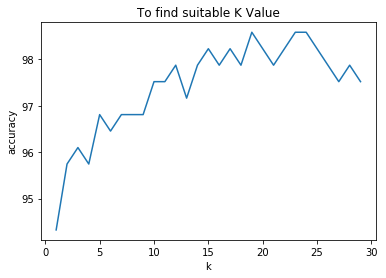

In [39]:
# To know the best value value of k  
from sklearn.metrics import accuracy_score
k_range = range(1, 30)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(dataset_train, target_train) # fitting the model
    predictedf = knn.predict(dataset_test) # predict the testset
    scores.append(accuracy_score(target_test, predictedf)*100) # evaluate accuracy
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_range, scores)
plt.xticks([0,5,10,15,20,25,30])
plt.title('To find suitable K Value')

From the plot we can see that, the Accuracy is best obtained at several points. We also get to know that increasing the number of neighbours above certain value does not increase but instead deteriorates the accuracy. ** Output may change if you run the above cell again as train and test set are randomly selected.

In [40]:
# k= 3
model.fit(dataset_train, target_train) # fitting the model
kpredicted = model.predict(dataset_test) # predict the testset
knn_accuracy=accuracy_score(target_test, kpredicted)*100
print("KNN_Accuracy : %.3f" % knn_accuracy) # evaluate accuracy

KNN_Accuracy : 95.745


An overall accuracy score for the predictions, defined as the fraction of correct predictions.

In [41]:
# build the confusion matrix
cm = confusion_matrix(target_test, kpredicted,labels=[0,1,2])
print(cm)

[[101   1   3]
 [  4 101   1]
 [  3   0  68]]


Text(0.5,1,'Confusion Matrix')

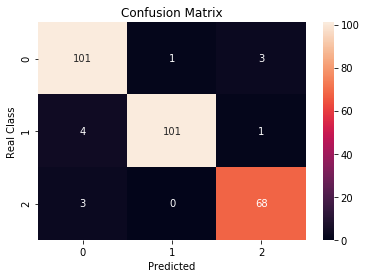

In [42]:
sns.heatmap(cm,annot=True,cbar=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Real Class")
plt.title('Confusion Matrix')

The result is a NumPy matrix, with predicted labels on the columns and True labels on the rows. The Values along the diagonal are True Positive's of each category.

In [43]:
# to know the number distinct category labels in testset of target(Category)
from collections import Counter
Counter(target_test.data.tolist()) #same as support

Counter({0: 105, 1: 106, 2: 71})

0: Business, 1: Sport, 2: technology

Classification results from my model are:

101 of the 105 examples in class 0(Business) were correctly labelled; 1 were misclassified to class 1(Sport) and 3 were misclassified to class 2(Technology).

101 of the 106 examples in class 1(Sport) were correctly labelled; 4 were misclassified to class 0(Business) and 1 were misclassified to class 2(Technology).

68 of the 71 examples in class 2(Technology) were correctly labelled; 3 were misclassified to class 0(Business) and 0 to class 1(Sport).

In [44]:
# Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, test, fd['Category'], cv=5,scoring="accuracy")
print("KNN_Mean_Cross-Validation_Accuracy : %.3f" % (scores.mean()*100))

KNN_Mean_Cross-Validation_Accuracy : 95.879


A problem with simply randomly splitting a dataset into two sets is that each random split might give different results. We are also ignoring a portion of your dataset. One way to address this is to use *k-fold cross-validation* to evaluate a classifier:
1. Divide the data into k disjoint subsets - “folds” (e.g. k=10).
2. For each of k experiments, use k-1 folds for training and the selected one fold for testing.
3. Repeat for all k folds, average the accuracy/error rates.

In [45]:
#computes a summary of statistics of Knn
from sklearn import metrics
print(metrics.classification_report(target_test, kpredicted, target_names=fd['labels'].unique()))

             precision    recall  f1-score   support

 technology       0.94      0.96      0.95       105
   business       0.99      0.95      0.97       106
      sport       0.94      0.96      0.95        71

avg / total       0.96      0.96      0.96       282



Measures from information retrieval (search engines) can be used in ML evaluation. Note that these are calculated with respect to a particular class (e.g. the positive class labelled as "1").
- *Precision*: proportion of retrieved results that are relevant = TP/(TP+FP)
- *Recall*: proportion of relevant results that are retrieved = TP/(TP+FN)
- *F1-Score*: Weighted average of the precision and recall which is just used to summarise what’s happening in the precision and recall. The F1 Measure reaches its best value at 1 and worst at 0.
- *support*: number of distinct category labels in testset of target(Category) 

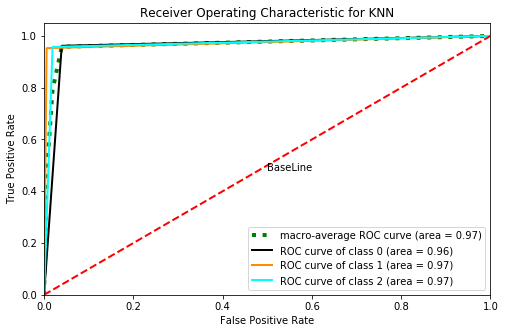

In [93]:
#ROC Curve for KNN
from sklearn.metrics import *
from scipy import interp
from itertools import cycle
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(target_test))[:, i], np.array(pd.get_dummies(kpredicted))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['black', 'darkorange', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('BaseLine',(.5,.48),color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="best")
plt.show()
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

The ROC plot uses (1-specificity) on the x-axis and sensitivity on the y-axis. True positive rate (TPR) is also caled recall. Receiver Operating Characteristic (ROC) is a metric to evaluate classifier output quality. A classifier with the perfect performance level shows a combination of two straight lines – from the origin (0.0, 0.0) to the top left corner (0.0, 1.0) and further to the top right corner (1.0, 1.0). We see that in this case with KNN as classification model there are 4 ROC curves as there are 3 labels and 1 for average of 3 labels. The AUC under ROC of each label is close to 1.0; larger area under the curve (AUC) is usually better. 

###### SVM

In [94]:
#number of features is really large compared to the training sample So using Linear kernal.
poly=SVC(C=1.0,kernel='linear') # linear kernal, Penalty parameter C of the error term.
poly.fit(dataset_train, target_train) # fitting the model
predicted=poly.predict(dataset_test)
svm_accuracy=accuracy_score(target_test, predicted)*100
print("SVM_Accuracy : %.3f" % svm_accuracy)
print('Coefficients:\n', poly.coef_)
print('Intercepts:\n', poly.intercept_)

SVM_Accuracy : 98.936
Coefficients:
 [[ 0.08935663 -0.2385017  -0.03099409 ..., -0.0774747   0.25061827
  -0.06890712]
 [ 0.28356294  0.          0.11394849 ...,  0.02698406  0.00489552
  -0.02820613]
 [-0.20544788  0.20161552 -0.03727572 ...,  0.15232677 -0.19927343
   0.05900973]]
Intercepts:
 [-0.00714511  0.19173892  0.18651071]


Coefficients: Weights assigned to the features.
Intercept: Constants in decision function.

In [47]:
#confusion Matrix
cm1 = confusion_matrix(target_test, predicted,labels=[0,1,2])
print(cm1)

[[103   0   2]
 [  0 106   0]
 [  1   0  70]]


Text(0.5,1,'Confusion Matrix')

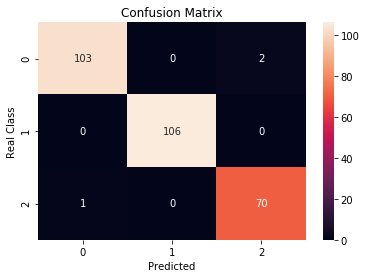

In [48]:
sns.heatmap(cm1,annot=True,cbar=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Real Class")
plt.title('Confusion Matrix')

The result is a NumPy matrix, with predictions on the columns and actual labels on the rows. The Values along the diagonal are TP's of each category.

In [49]:
# to know the number distinct category labels in testset of target(Category)
Counter(target_test.data.tolist()) #same as support

Counter({0: 105, 1: 106, 2: 71})

0: Business, 1: Sport, 2: technology

Classification results from my model are:

103 of the 105 examples in class 0(Business) were correctly labelled; 0 were misclassified to class 1(Sport) and 2 were misclassified to class 2(Technology).

106 of the 106 examples in class 1(Sport) were correctly labelled; 0 were misclassified to class 0(Business) and 0 were misclassified to class 2(Technology) . 

70 of the 71 examples in class 2(Technology) were correctly labelled; 1 were misclassified to class 0(Business) and 0 to class 1(Sport).

In [53]:
acc_scores1 = cross_val_score(poly, test, fd['Category'], cv=5, scoring="accuracy")
print("SVM: Mean cross-validation accuracy = %.3f" % (acc_scores1.mean() *100))

SVM: Mean cross-validation accuracy = 98.295


In [51]:
#compute a summary of statistics of SVM
print(metrics.classification_report(target_test, predicted, target_names=fd['labels'].unique()))

             precision    recall  f1-score   support

 technology       0.99      0.98      0.99       105
   business       1.00      1.00      1.00       106
      sport       0.97      0.99      0.98        71

avg / total       0.99      0.99      0.99       282



Recall is a performance measure of the whole positive part of a dataset, whereas precision is a performance measure of positive predictions.

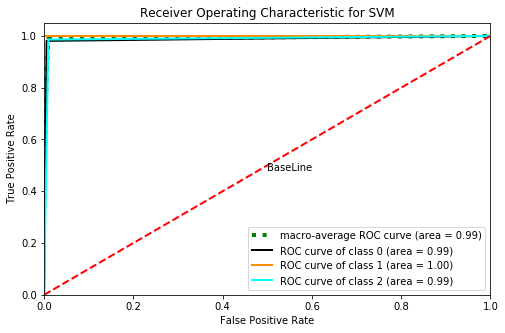

In [92]:
#ROC Curve for SVM
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(target_test))[:, i], np.array(pd.get_dummies(predicted))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['black', 'darkorange', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('BaseLine',(.5,.48),color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="best")
plt.show()
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Receiver Operating Characteristic (ROC) is a metric to evaluate classifier output quality. A classifier with the perfect performance level shows a combination of two straight lines – from the origin (0.0, 0.0) to the top left corner (0.0, 1.0) and further to the top right corner (1.0, 1.0). We see that in this case with SVM as classification model there are 4 ROC curves as there are 3 labels and 1 for average of 3 labels. The AUC under ROC of each label is alomst 1.0; larger area under the curve (AUC) is usually better. The plot shows that SVM is a best Classifier for this dataset. 

# Conclusion

([<matplotlib.axis.YTick at 0x1753a6ca4a8>,
 <a list of 2 Text yticklabel objects>)

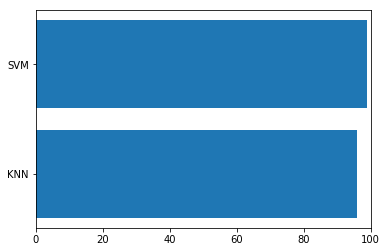

In [52]:
accuracy={'KNN':knn_accuracy,'SVM':svm_accuracy}
plt.xlim(0,100)
plt.barh(range(len(accuracy)),list(accuracy.values()))
plt.yticks(range(len(accuracy)),list(accuracy.keys()))

###### I have chosen 'KNN' beacuse it is one of the popular and efficient clasiification algorithm and 'SVM' because the number of features are high compared to a number of data points in the dataset and the sparsity is also high. Also SVM is popular in text classification problems with very high-dimensional spaces.

###### SVM has 98.93% accuracy over KNN's 95.74%. We also got to know that the precision and recall for SVM (99%) is greater than KNN(96%) which determines the accuracy and the ROC plot for both classifiers imply that the AUC for SVM is greater than KNN, this is because of the number of True Positives identified by the SVM (279) are higher over KNN(270) on 282 examples. 
###### SVM is better than KNN for this dataset as in KNN the best 'k' value should be set forehand to build the model and also if the 'k' value is small it'll be susceptible to noise and if 'k' is higher than it would computaionally expensive. Also, in a very high dimensional space the distance to all neighbors becomes more or less the same, and the notion of nearest and far neighbors becomes blurred. The performance of the KNN classifier is dependent on the number of neighbours, which is assigned through empirical analysis (by checking for various values of 'k'). 
##### So on the whole, SVM outperforms KNN in every aspect of comparison.